In [ ]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

  Cloning https://github.com/undark-lab/swyft.git to /tmp/pip-req-build-4a18fx4o
  Running command git clone -q https://github.com/undark-lab/swyft.git /tmp/pip-req-build-4a18fx4o
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 2.8 MB/s 
     |████████████████████████████████| 146 kB 48.3 MB/s 
     |████████████████████████████████| 23.1 MB 1.2 MB/s 
     |████████████████████████████████| 6.2 MB 10.0 MB/s 
     |████████████████████████████████| 125 kB 57.4 MB/s 
     |████████████████████████████████| 786 kB 47.1 MB/s 
  Created wheel for swyft: filename=swyft-0.2.1.dev52+g8a6d53e-py3-none-any.whl size=59466 sha256=6bc76aaf4c71014017ff01ba64cd3c71b2990c6927236cb8e7b7e05a1b36d45c
  Stored in directory: /tmp/pip-ephem-wheel-cache-vjt34_tc/wheels/2f/17/1b/d5a3f29a80fc800cada79f76285fe179aa7814cb106e5c16e2
  Created wheel for asciitree: filename=asciitree-0.3.3-py

# Using a directory-based/permanent store

`SWYFT` enables users to perform efficient simulation based inferrence using simulators of their choice (as demonstrated in the External Simulator notebook). While these simulators may be light-weight in many cases, in general they may constitute a significant amouunt of computational time. E.g., should a simulator require 10 seconds to produce a result, then a scenario such as in Quickstart.ipynb would already require more than 8 hours of CPU time for the imulations alone.

Many simulators are even more compuutationally expensive, making the ability to reuse simulations across experiments of paramount importance.

`SWYFT` addresses this issue with the `DirectoryStore` option, which serializes the sttore to disk using `zarr`. This enables a user to store and reuse simulations (provided they were created using **the same** settings) and even for multiple users/processes to share a store, dramattically increasing efficiency.

Here, we briefly demonstrate the use of a directory-based store instead of an in-memory store, again on the basis of the `Quickstart.ipynb` notebook. 

In [ ]:
import numpy as np
import pylab as plt
import swyft

In [ ]:
DEVICE = 'cpu'
Ntrain =3000
Npars = 2

In [ ]:
def model(v, sigma = 0.2):
    x = v + np.random.randn(Npars)*sigma
    return dict(x=x)

In [ ]:
import os
cwd = os.getcwd()


In [ ]:
simulator = swyft.Simulator(model, Npars, sim_shapes = {"x": (Npars,)})

## The directory store

The directory store is specified using the `DirectoryStore` class. The user must specify the path to the store. If the store doesn't exist, it will be created. Otherwise, `SWYFT` will connect to and reuse an existing store. 

In [ ]:
store = swyft.DirectoryStore(cwd+'/mystore',simulator=simulator)

Creating new store.


In [ ]:
prior = swyft.Prior(lambda u: u*2-1, Npars)
store.add(Ntrain, prior)
store.simulate()

Store: Adding 2939 new samples to simulator store.


In [ ]:
dataset = swyft.Dataset(Ntrain, prior, store)
post = swyft.Posteriors(dataset)


In [ ]:
post.add([(0, 1)], device=DEVICE)
post.train([(0, 1)], max_epochs = 20)

Training: lr=0.001, Epoch=15, VL=0.5297


In [ ]:
v0 = np.zeros(Npars)
obs0 = model(v0, sigma = 0.)

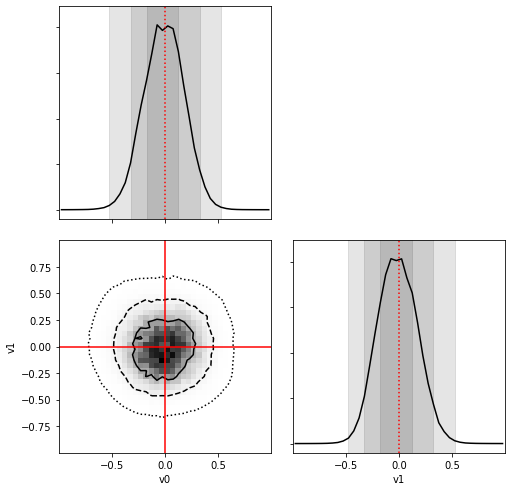

In [ ]:
samples = post.sample(100000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);